In [1]:
from bagpy import bagreader

b = bagreader("/home/daniel/Documents/data/xfer_learning/grub_data_collection/base_grub_data.bag")
b.topic_table

[INFO]  Data folder /home/daniel/Documents/data/xfer_learning/grub_data_collection/base_grub_data already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/robo_0/joint_0/angle_state,sensor_msgs/JointState,4521,501.201410
1,/robo_0/joint_0/pressure_command,rad_msgs/PressureStamped,904,99.978642
2,/robo_0/joint_0/pressure_state,rad_msgs/PressureStamped,4521,500.036242
3,/rosout,rosgraph_msgs/Log,9,65027.968992
4,/vive/pose_0,geometry_msgs/PoseStamped,9042,1001.027208
5,/vive/pose_1,geometry_msgs/PoseStamped,9041,1000.788356
6,/vive/twist_0,geometry_msgs/TwistStamped,9041,1000.549618
7,/vive/twist_1,geometry_msgs/TwistStamped,9040,1000.549618


In [2]:
from bagpy import bagreader
from moldy.utils.bag_utils import bag_to_csv_data_collection
import os

# outer_path = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/"
# outer_path = "/home/daniel/Documents/data/xfer_learning/prev_grub_data_collection/"
rate = 0.01

topic_names = [["/robo_0/joint_0/angle_state"],
               ["/robo_0/joint_0/pressure_state"], 
               ["/robo_0/joint_0/pressure_command"],]

# for experiment in os.listdir(outer_path):
#     if experiment[-4:] == ".bag":
#         print(f"Running experiment: {experiment}\n\n")
#         try:
#             save_path = f"{outer_path}/parsed_csvs/"+experiment.split(".")[0]+"/"
#             os.makedirs(save_path, exist_ok=False)
#             bag_dir = outer_path + experiment
#             b = bagreader(bag_dir)

#             bag_to_csv_data_collection(b, save_path, topic_names, rate)
#         except Exception as e:
#             print(f"Failed on {experiment} with error: {e}")
#             continue

outer_path = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/sideways_weight_grub_data_MAIN/"


save_path = f"{outer_path}/parsed_csvs_TEST/"
os.makedirs(save_path, exist_ok=False)
bag_dir = outer_path + "sideways_weight_TEST_data.bag"
b = bagreader(bag_dir)

bag_to_csv_data_collection(b, save_path, topic_names, rate)

[INFO]  Successfully created the data folder /home/daniel/Documents/data/xfer_learning/grub_data_collection/sideways_weight_grub_data_MAIN/sideways_weight_TEST_data.


['/home/daniel/Documents/data/xfer_learning/grub_data_collection/sideways_weight_grub_data_MAIN//parsed_csvs_TEST//joint0.csv']

In [5]:
# Convert CSVs to numpy arrays in the correct format
import os
import numpy as np
from moldy.utils.bag_utils import get_data_from_csv

# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/parsed_csvs/base_grub_data/not_smooth_joint0.csv"
# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/prev_grub_data_collection/parsed_csvs/grub_hw_2023-09-25-10-22-48/not_smooth_joint0.csv"
path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/sideways_weight_grub_data_MAIN/parsed_csvs_TEST/not_smooth_joint0.csv"

# save_path = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/parsed_csvs/base_grub_data/"
# save_path = "/home/daniel/Documents/data/xfer_learning/prev_grub_data_collection/parsed_csvs/grub_hw_2023-09-25-10-22-48/"
save_path = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/sideways_weight_grub_data_MAIN/parsed_csvs_TEST/"


not_smooth_joint0_data = get_data_from_csv(path_to_all_csvs)

not_smooth_combined_state = np.zeros((not_smooth_joint0_data.shape[0], 12))
not_smooth_combined_control_input = np.zeros((not_smooth_joint0_data.shape[0], 4))

not_smooth_combined_state[:, :4] = not_smooth_joint0_data[:, 1:5]
not_smooth_combined_state[:, 4:6] = not_smooth_joint0_data[:, 5:7]
not_smooth_combined_state[:, 6:8] = not_smooth_joint0_data[:, 7:9]
not_smooth_combined_state[:, -4:] = not_smooth_joint0_data[:, -4:]         

not_smooth_output_data = not_smooth_combined_state[1:, :8] - not_smooth_combined_state[:-1, :8]
not_smooth_input_data = not_smooth_combined_state[:-1, :]

np.save(save_path+"/"+"/not_smooth_all_inputs.npy", not_smooth_input_data)
np.save(save_path+"/"+"/not_smooth_all_outputs.npy", not_smooth_output_data)

print(f"not_smooth_data_list_inputs shape: {not_smooth_input_data.shape}", f"not_smooth_data_list_outputs shape: {not_smooth_output_data.shape}")

not_smooth_data_list_inputs shape: (71298, 12) not_smooth_data_list_outputs shape: (71298, 8)


In [6]:
not_smooth_joint0_data[1, 0] - not_smooth_joint0_data[0, 0]

0.0099999904632568

In [7]:
from scipy.signal import sosfiltfilt, butter

# def smooth_finite_diff(x, cutoff_freq=1.0):
#     sos = butter(8, cutoff_freq, output='sos', fs=100)
#     y = sosfiltfilt(sos, x)
#     return y


import pynumdiff
import pynumdiff.optimize

# smooth and numerically differentiate the pressure data
num_data_points = 20000

def smooth_finite_diff(x, dt=0.01, cutoff_frequency=1, num_data_points=20000, data_start=0):
    # estimate by (a) counting real # peaks per second in the data or (b) look at power spectra and choose cutoff. 
    # log_gamma = -1.6*np.log(cutoff_frequency) -0.71*np.log(dt) - 5.1
    # tvgamma = np.exp(log_gamma)   

    # params, val = pynumdiff.optimize.linear_model.savgoldiff(x[data_start:num_data_points+data_start], dt, params=None, 
    #                                                                 options={'iterate': True},
    #                                                                 tvgamma=tvgamma,
    #                                                                 dxdt_truth=None)
    # print('Optimal parameters: ', params)
    params = [5, 35, 15]
    # sos = butter(8, 1.25, output='sos', fs=100)
    # x = sosfiltfilt(sos, x)
    x_hat, dxdt_hat = pynumdiff.linear_model.savgoldiff(x, dt, params, options={'iterate': True})

    return x_hat, dxdt_hat

In [16]:
# read in all arrays, smooth them and then concatenate them into one big array
import os
import numpy as np

# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/parsed_csvs/base_grub_data/"
# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/prev_grub_data_collection/parsed_csvs/grub_hw_2023-09-25-10-22-48/"
path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/sideways_weight_grub_data_MAIN/parsed_csvs_MAIN/"

not_smooth_input_data = np.load(path_to_all_csvs+"/not_smooth_all_inputs.npy")
not_smooth_output_data = np.load(path_to_all_csvs+"/not_smooth_all_outputs.npy")

smooth_all_inputs_list = []
smooth_all_outputs_list = []

smoothed_input_data = np.zeros(not_smooth_input_data.shape)
smoothed_output_data = np.zeros(not_smooth_output_data.shape)

for j in range(8):
    if j < 4:
        p_hat, pdot_hat = smooth_finite_diff(not_smooth_input_data[:, j])
        smoothed_input_data[:, j] = p_hat
    elif j < 6:
        continue
    else:
        angle, angle_dot = smooth_finite_diff(not_smooth_input_data[:, j])
        smoothed_input_data[:, j] = angle
        smoothed_input_data[:, j-2] = angle_dot

smoothed_input_data[:, -4:] = not_smooth_input_data[:, -4:]
smoothed_output_data = smoothed_input_data[1:, :8] - smoothed_input_data[:-1, :8]
smoothed_input_data = smoothed_input_data[:-1, :]

smooth_all_inputs_list.append(smoothed_input_data)
smooth_all_outputs_list.append(smoothed_output_data)

smooth_all_inputs = np.concatenate(smooth_all_inputs_list, axis=0)
smooth_all_outputs = np.concatenate(smooth_all_outputs_list, axis=0)

np.save(path_to_all_csvs+"/smooth_all_inputs.npy", smooth_all_inputs)
np.save(path_to_all_csvs+"/smooth_all_outputs.npy", smooth_all_outputs)

print(smooth_all_inputs.shape, smooth_all_outputs.shape)

(362944, 12) (362944, 8)


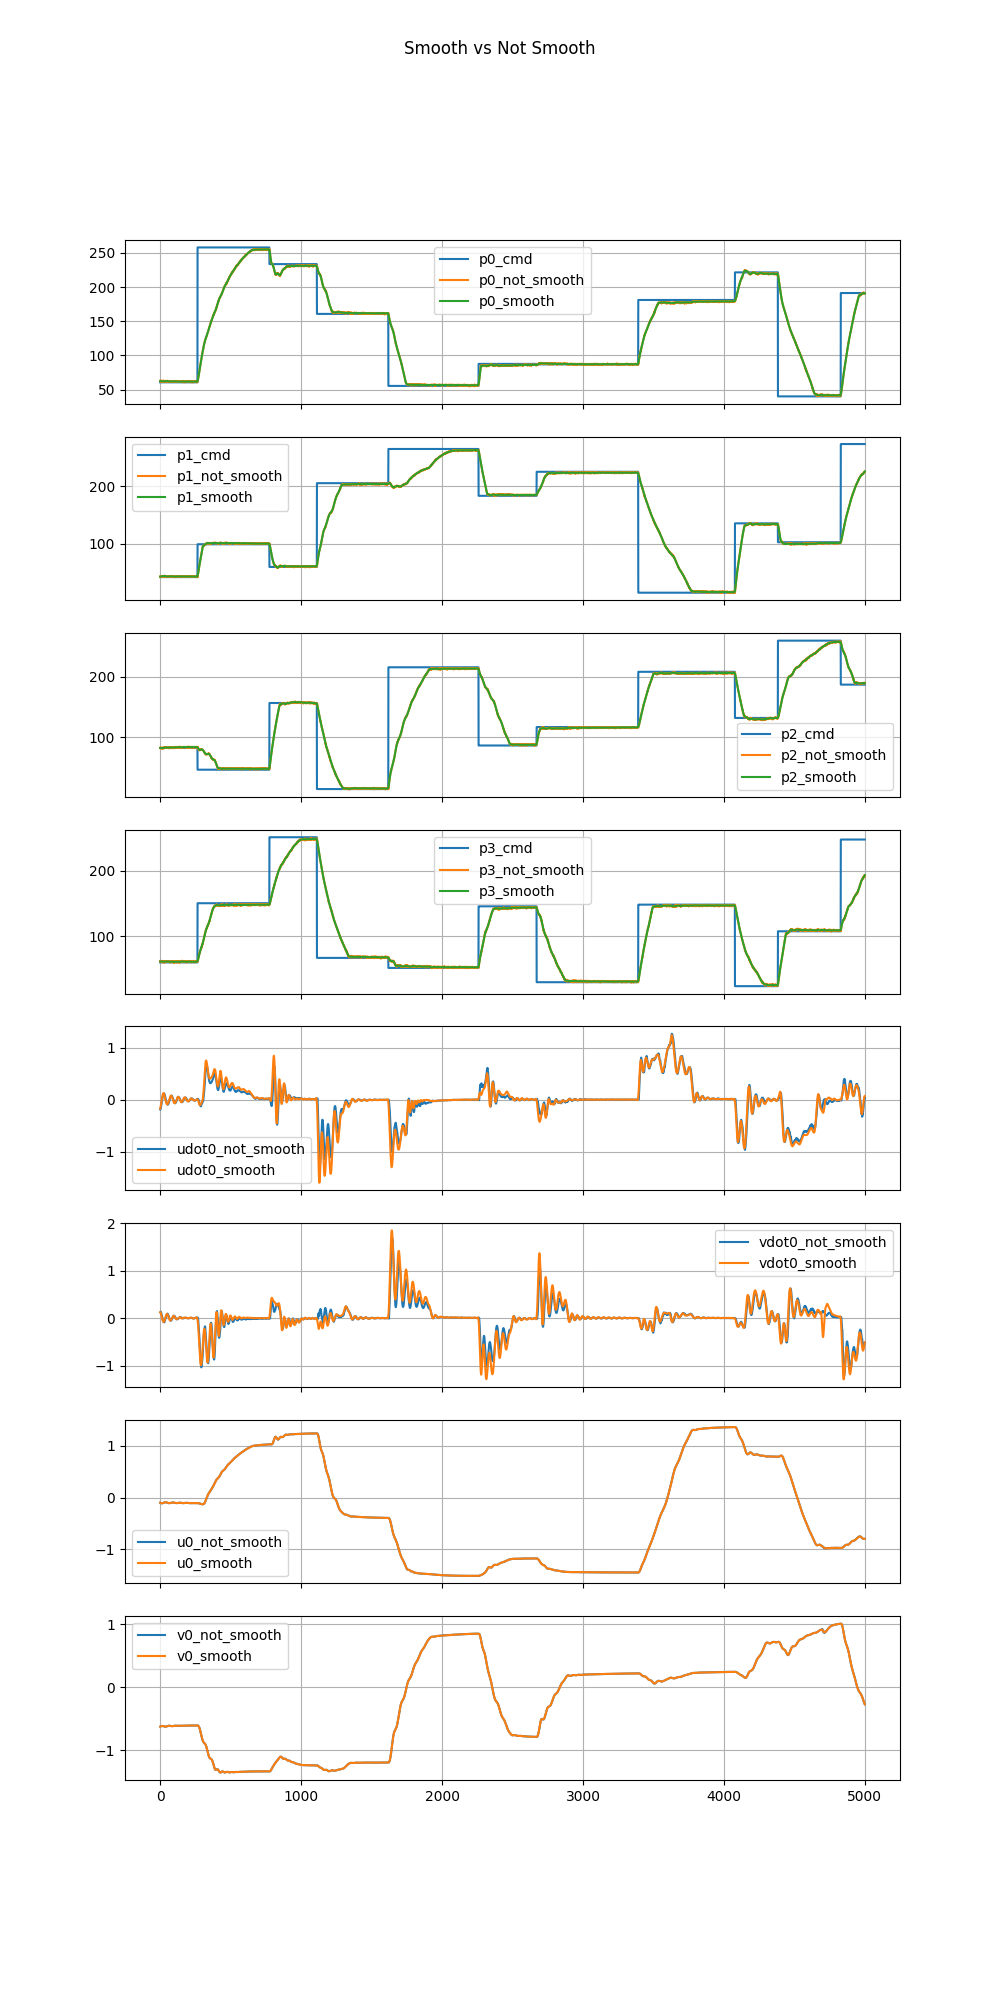

In [18]:
%matplotlib widget

# plot all of the states to compare smooth and not smooth
import matplotlib.pyplot as plt
import numpy as np

start_ind = 5000
end_ind = 10000

# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/parsed_csvs/base_grub_data/"
# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/prev_grub_data_collection/parsed_csvs/grub_hw_2023-09-25-10-22-48/"
path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/sideways_weight_grub_data_MAIN/parsed_csvs_MAIN/"


smooth_all_inputs = np.load(path_to_all_csvs+"/smooth_all_inputs.npy")
smooth_all_outputs = np.load(path_to_all_csvs+"/smooth_all_outputs.npy")

not_smooth_all_inputs = np.load(path_to_all_csvs+"/not_smooth_all_inputs.npy")
not_smooth_all_outputs = np.load(path_to_all_csvs+"/not_smooth_all_outputs.npy")

fig, axs = plt.subplots(8, 1, sharex=True, figsize=(10, 20))
fig.suptitle('Smooth vs Not Smooth')
labels = ["p0", "p1", "p2", "p3", "udot0", "vdot0", "u0", "v0"]

for i in range(4):
    axs[i].plot(smooth_all_inputs[start_ind:end_ind, i+8], label=f"{labels[i]}_cmd")
    axs[i].plot(not_smooth_all_inputs[start_ind:end_ind, i], label=f"{labels[i]}_not_smooth")
    axs[i].plot(smooth_all_inputs[start_ind:end_ind, i], label=f"{labels[i]}_smooth")
    axs[i].legend()
    axs[i].grid()

for i in range(4, 8):
    axs[i].plot(not_smooth_all_inputs[start_ind:end_ind, i], label=f"{labels[i]}_not_smooth")
    axs[i].plot(smooth_all_inputs[start_ind:end_ind, i], label=f"{labels[i]}_smooth")
    axs[i].legend()
    axs[i].grid()

In [20]:
from moldy.case_studies.grub_hw.learnedModel_grub_hw import LearnedModel_GrubHW

import numpy as np

model = LearnedModel_GrubHW()

# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/parsed_csvs/base_grub_data/"
# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/prev_grub_data_collection/parsed_csvs/grub_hw_2023-09-25-10-22-48/"
path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/sideways_weight_grub_data_MAIN/parsed_csvs_MAIN/"


smooth_all_inputs = np.load(path_to_all_csvs+"/smooth_all_inputs.npy")
smooth_all_outputs = np.load(path_to_all_csvs+"/smooth_all_outputs.npy")

not_smooth_all_inputs = np.load(path_to_all_csvs+"/not_smooth_all_inputs.npy")
not_smooth_all_outputs = np.load(path_to_all_csvs+"/not_smooth_all_outputs.npy")

all_smooth_inputs_normalized = np.zeros(smooth_all_inputs.shape)
all_smooth_outputs_normalized = np.zeros(smooth_all_outputs.shape)

all_not_smooth_inputs_normalized = np.zeros(not_smooth_all_inputs.shape)
all_not_smooth_outputs_normalized = np.zeros(not_smooth_all_outputs.shape)

############################### MEAN STD NORMALIZATION ###############################
# state_mean = ((model.xMax + model.xMin) / 2).cpu().numpy()
# state_std = ((model.xMax - model.xMin) / 2).cpu().numpy()
# input_mean = ((model.uMax + model.uMin) / 2).cpu().numpy()
# input_std = ((model.uMax - model.uMin) / 2).cpu().numpy()

# all_smooth_inputs_normalized[:, :8] = (smooth_all_inputs[:, :8] - state_mean) / state_std
# all_smooth_inputs_normalized[:, 8:] = (smooth_all_inputs[:, 8:] - input_mean) / input_std
# all_smooth_outputs_normalized = (smooth_all_outputs - state_mean) / state_std

# all_not_smooth_inputs_normalized[:, :8] = (not_smooth_all_inputs[:, :8] - state_mean) / state_std
# all_not_smooth_inputs_normalized[:, 8:] = (not_smooth_all_inputs[:, 8:] - input_mean) / input_std
# all_not_smooth_outputs_normalized = (not_smooth_all_outputs - state_mean) / state_std

# input_max_not_smooth = np.max(not_smooth_all_inputs, axis=0)
# output_max_not_smooth = np.max(not_smooth_all_outputs, axis=0)
############################### MEAN STD NORMALIZATION ###############################



######################## MAX NORMALIZATION ########################
input_max_smooth = np.hstack([model.xMax.cpu().numpy(), model.uMax.cpu().numpy()])
# output_max = np.max(smooth_all_outputs, axis=0)
output_max = np.load("/home/daniel/catkin_ws/src/moldy/case_studies/grub_sim/data/output_max.npy")

all_smooth_inputs_normalized = smooth_all_inputs / input_max_smooth
all_smooth_outputs_normalized = smooth_all_outputs / output_max

all_not_smooth_inputs_normalized = not_smooth_all_inputs / input_max_smooth
all_not_smooth_outputs_normalized = not_smooth_all_outputs / output_max

######################## MAX NORMALIZATION ########################

np.save(path_to_all_csvs+"/smooth_all_inputs_normalized.npy", all_smooth_inputs_normalized)
np.save(path_to_all_csvs+"/smooth_all_outputs_normalized.npy", all_smooth_outputs_normalized)

np.save(path_to_all_csvs+"/not_smooth_all_inputs_normalized.npy", all_not_smooth_inputs_normalized)
np.save(path_to_all_csvs+"/not_smooth_all_outputs_normalized.npy", all_not_smooth_outputs_normalized)

GrubSim: mass: 5.0, stiffness: 14.07, damping: 2.73, alpha: 2.856, h: 0.23, r: 0.095


In [21]:
output_max

array([7.43301041, 7.60212488, 7.51765683, 7.57394068, 0.89510595,
       0.63693608, 0.06397356, 0.06485411])

In [23]:
# remove outliers from the data
from scipy import stats

# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/parsed_csvs/base_grub_data/"
# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/prev_grub_data_collection/parsed_csvs/grub_hw_2023-09-25-10-22-48/"
path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/sideways_weight_grub_data_MAIN/parsed_csvs_MAIN/"


all_smooth_inputs_normalized = np.load(f"{path_to_all_csvs}/smooth_all_inputs_normalized.npy")
all_smooth_outputs_normalized = np.load(f"{path_to_all_csvs}/smooth_all_outputs_normalized.npy")

z_scores = stats.zscore(all_smooth_inputs_normalized)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
all_smooth_inputs_normalized_filtered = all_smooth_inputs_normalized[filtered_entries]
all_smooth_outputs_normalized_filtered = all_smooth_outputs_normalized[filtered_entries]

z_scores = stats.zscore(all_smooth_outputs_normalized_filtered)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
all_smooth_inputs_normalized_filtered = all_smooth_inputs_normalized_filtered[filtered_entries]
all_smooth_outputs_normalized_filtered = all_smooth_outputs_normalized_filtered[filtered_entries]

all_not_smooth_inputs_normalized = np.load(f"{path_to_all_csvs}/not_smooth_all_inputs_normalized.npy")
all_not_smooth_outputs_normalized = np.load(f"{path_to_all_csvs}/not_smooth_all_outputs_normalized.npy")

z_scores = stats.zscore(all_not_smooth_inputs_normalized)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
all_not_smooth_inputs_normalized_filtered = all_not_smooth_inputs_normalized[filtered_entries]
all_not_smooth_outputs_normalized_filtered = all_not_smooth_outputs_normalized[filtered_entries]

z_scores = stats.zscore(all_not_smooth_outputs_normalized_filtered)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
all_not_smooth_inputs_normalized_filtered = all_not_smooth_inputs_normalized_filtered[filtered_entries]
all_not_smooth_outputs_normalized_filtered = all_not_smooth_outputs_normalized_filtered[filtered_entries]

np.save(f"{path_to_all_csvs}/smooth_all_inputs_normalized_filtered.npy", all_smooth_inputs_normalized_filtered)
np.save(f"{path_to_all_csvs}/smooth_all_outputs_normalized_filtered.npy", all_smooth_outputs_normalized_filtered)

np.save(f"{path_to_all_csvs}/not_smooth_all_inputs_normalized_filtered.npy", all_not_smooth_inputs_normalized_filtered)
np.save(f"{path_to_all_csvs}/not_smooth_all_outputs_normalized_filtered.npy", all_not_smooth_outputs_normalized_filtered)

print(all_smooth_inputs_normalized_filtered.shape, all_smooth_outputs_normalized_filtered.shape, all_not_smooth_inputs_normalized_filtered.shape, all_not_smooth_outputs_normalized_filtered.shape)

(342824, 12) (342824, 8) (348692, 12) (348692, 8)


In [25]:
import numpy as np
# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/parsed_csvs/base_grub_data/"
# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/prev_grub_data_collection/parsed_csvs/grub_hw_2023-09-25-10-22-48/"
path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/sideways_weight_grub_data_MAIN/parsed_csvs_MAIN/"

# all_inputs_normalized = np.load(path_to_all_csvs + "smooth_all_inputs_normalized_filtered.npy")
# all_outputs_normalized = np.load(path_to_all_csvs + "smooth_all_outputs_normalized_filtered.npy")

all_inputs_normalized = np.load(path_to_all_csvs + "not_smooth_all_inputs_normalized_filtered.npy")
all_outputs_normalized = np.load(path_to_all_csvs + "not_smooth_all_outputs_normalized_filtered.npy")

train_size = int(0.80*all_inputs_normalized.shape[0])
validation_size = int(0.20*all_inputs_normalized.shape[0])


train_inputs = all_inputs_normalized[:train_size]
val_inputs = all_inputs_normalized[train_size:]
train_outputs = all_outputs_normalized[:train_size]
val_outputs = all_outputs_normalized[train_size:]

val_inputs = val_inputs.astype(np.float32)
val_outputs = val_outputs.astype(np.float32)
train_inputs = train_inputs.astype(np.float32)
train_outputs = train_outputs.astype(np.float32)

np.save("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/raw/validation_inputdata.npy", val_inputs)
np.save("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/raw/validation_outputdata.npy", val_outputs)
np.save("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/raw/train_inputdata.npy", train_inputs)
np.save("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/raw/train_outputdata.npy", train_outputs)
np.save("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/raw/output_max.npy", output_max)

print(train_inputs.shape, val_inputs.shape, train_outputs.shape, val_outputs.shape)

(278953, 12) (69739, 12) (278953, 8) (69739, 8)


In [31]:

import numpy as np

model = LearnedModel_GrubHW()

validation_set = np.load("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/smooth/validation_inputdata.npy")

######################## MAX NORMALIZATION ########################
input_max_smooth = np.hstack([model.xMax.cpu().numpy(), model.uMax.cpu().numpy()])

validation_set = validation_set * input_max_smooth

np.save("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/smooth/validation_inputdata.npy", validation_set)

GrubSim: mass: 5.0, stiffness: 14.07, damping: 2.73, alpha: 2.856, h: 0.23, r: 0.095


In [32]:
import numpy as np
# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/parsed_csvs/base_grub_data/"
# path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/prev_grub_data_collection/parsed_csvs/grub_hw_2023-09-25-10-22-48/"
path_to_all_csvs = "/home/daniel/Documents/data/xfer_learning/grub_data_collection/sideways_weight_grub_data_MAIN/parsed_csvs_MAIN/"


all_inputs_normalized = np.load(path_to_all_csvs + "smooth_all_inputs_normalized_filtered.npy")
all_outputs_normalized = np.load(path_to_all_csvs + "smooth_all_outputs_normalized_filtered.npy")

# all_inputs_normalized = np.load(path_to_all_csvs + "not_smooth_all_inputs_normalized_filtered.npy")
# all_outputs_normalized = np.load(path_to_all_csvs + "not_smooth_all_outputs_normalized_filtered.npy")

train_size = int(0.80*all_inputs_normalized.shape[0])
validation_size = int(0.20*all_inputs_normalized.shape[0])

train_inputs = all_inputs_normalized[:train_size]
val_inputs = all_inputs_normalized[train_size:]
train_outputs = all_outputs_normalized[:train_size]
val_outputs = all_outputs_normalized[train_size:]

val_inputs = val_inputs.astype(np.float32)
val_outputs = val_outputs.astype(np.float32)
train_inputs = train_inputs.astype(np.float32)
train_outputs = train_outputs.astype(np.float32)


np.save("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/smooth/validation_inputdata.npy", val_inputs)
np.save("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/smooth/validation_outputdata.npy", val_outputs)
np.save("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/smooth/train_inputdata.npy", train_inputs)
np.save("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/smooth/train_outputdata.npy", train_outputs)
np.save("/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/data/good_data/max_normalization/smooth/output_max.npy", output_max)


print(train_inputs.shape, val_inputs.shape, train_outputs.shape, val_outputs.shape)

(274259, 12) (68565, 12) (274259, 8) (68565, 8)
